In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import scipy.special
import torch.nn as nn
import torch.nn.functional as F


from torch import nn
from collections import Counter
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import to_hetero
from sklearn.metrics import roc_auc_score
from torch_geometric.data import HeteroData
from sklearn.preprocessing import LabelEncoder
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import RandomLinkSplit

In [3]:

# Load full merged data (lncTarD + STRING)
df = pd.read_excel('data/merged_lnctard_STring.xlsx')

# Quick check
df.head()


,node1,node2,interaction,disease,source
0,LINC00313,miR-4429,binding/interaction,Papillary thyroid carcinoma,lncRNA
1,FAM83H-AS1,CDKN1A,regulation,Malignant glioma,lncRNA
2,NEAT1,TGFB1,association,Hepatocellular carcinoma,lncRNA
3,NEAT1,ZEB1,regulation,Breast cancer,lncRNA
4,ZFPM2-AS1,MIF,binding/interaction,Gastric cancer,lncRNA


In [4]:

# Prepare node Features from dataframe (df)
#------------------------------------------

# Collect all unique node IDs from both node1 and node2 columns
all_nodes = pd.concat([df['node1'], df['node2']]).unique()

# Encode node IDs into numeric values (e.g., "P12345" → 0, "lncX" → 1, etc.)
node_encoder = LabelEncoder()
node_encoder.fit(all_nodes)
node_ids_encoded = node_encoder.transform(all_nodes)

# Create a dictionary to store the type of each node (lncRNA or protein)
node_type_map = {}

# Assign type from 'source' column (for node1)
for node, t in zip(df['node1'], df['source']):
    node_type_map[node] = t

# node2 entries are always proteins
for node in df['node2']:
    node_type_map[node] = 'protein'

# Convert node type to a numeric feature
# We'll use 1 for lncRNA, and 0 for protein
type_feature = []
for node in all_nodes:
    t = node_type_map.get(node, 'protein')  # Default to 'protein' if not found
    type_feature.append(1 if t == 'lncRNA' else 0)
    

    
# Convert to numpy array and reshape to (num_nodes, 1)
type_feature = np.array(type_feature).reshape(-1, 1)

print(type_feature)

# Compute degree of each node (number of times it appears in edges)

# Count appearances in both node1 and node2
degree_counter = Counter(pd.concat([df['node1'], df['node2']]))

# Create degree feature for each node
degree_feature = np.array([degree_counter[node] for node in all_nodes]).reshape(-1, 1)

# Combine type and degree features into a single array
# Each node feature vector will look like: [type, degree]
node_features = np.concatenate([type_feature, degree_feature], axis=1)


# Convert node features to a PyTorch tensor for use in GNN models
node_features_tensor = torch.tensor(node_features, dtype=torch.float)



[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [5]:
## final tensor which has all node features (node tyoe + node degree) for all nodes

print("Node feature shape:", node_features_tensor.shape)
print(node_features_tensor)   

Node feature shape: torch.Size([20232, 2])
tensor([[  1.,   5.],
        [  1.,   2.],
        [  0., 211.],
        ...,
        [  0.,   1.],
        [  0.,   1.],
        [  0.,   1.]])


In [6]:
# Create an empty heterogeneous graph object
data = HeteroData()

# We use the type_feature created earlier
# Convert the type_feature array to a PyTorch tensor
# We use long type because we will use it for indexing
node_type_tensor = torch.tensor(type_feature, dtype=torch.long)


# Get indices of nodes by type:
# lncRNA_indices: indices where type == 1
# protein_indices: indices where type == 0
lncRNA_indices = (node_type_tensor == 1).nonzero(as_tuple=True)[0]
protein_indices = (node_type_tensor == 0).nonzero(as_tuple=True)[0]

# Assign node features for each node type
# Split the full node features tensor based on type
# and assign each to the correct node type in HeteroData
data['lncRNA'].x = node_features_tensor[lncRNA_indices]
data['protein'].x = node_features_tensor[protein_indices]

print(len(data['lncRNA'].x))
print(data['lncRNA'].x)

print(len(data['protein'].x))
print(data['protein'].x)


1221
tensor([[1., 5.],
        [1., 2.],
        [1., 5.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]])
19011
tensor([[  0., 211.],
        [  0.,  73.],
        [  0., 331.],
        ...,
        [  0.,   1.],
        [  0.,   1.],
        [  0.,   1.]])


In [9]:
# split edges (lncRNA-> protein)    or    (protein -> protein) 
# Filter by source column

## (lncRNA -> protein) edges
#----------------------------
# Select only rows where the source node is of type lncRNA
df_lnc_protein = df[df['source'] == 'lncRNA'].copy()

## (protein -> protein) edges
#----------------------------
# Select all other edges where the source node is NOT lncRNA
df_protein_protein = df[df['source'] != 'lncRNA'].copy()

print("lncRNA–protein edges:", len(df_lnc_protein))
print(df_lnc_protein)
print("protein–protein edges:", len(df_protein_protein))
print(df_protein_protein)


lncRNA–protein edges: 7773
           node1     node2          interaction  \
0      LINC00313  miR-4429  binding/interaction   
1     FAM83H-AS1    CDKN1A           regulation   
2          NEAT1     TGFB1          association   
3          NEAT1      ZEB1           regulation   
4      ZFPM2-AS1       MIF  binding/interaction   
...          ...       ...                  ...   
7768       HCG18     FGFR1           regulation   
7769      IQANK1     MEF2D           regulation   
7770       HCG22   miR-650  binding/interaction   
7771        PVT1     FOXM1           regulation   
7772   MIR3936HG     STMN1  binding/interaction   

                                disease  source  
0           Papillary thyroid carcinoma  lncRNA  
1                      Malignant glioma  lncRNA  
2              Hepatocellular carcinoma  lncRNA  
3                         Breast cancer  lncRNA  
4                        Gastric cancer  lncRNA  
...                                 ...     ...  
7768  Lary

In [14]:
# Filter out rows where 'combine_score' is less than 700
df_protein_protein = df_protein_protein[df_protein_protein['interaction'] >= 700]

# (Optional) Save the result to a new Excel file
#filtered_string_df.to_excel("filtered_STRING_DB.xlsx", index=False)

print("protein–protein edges:", len(df_protein_protein))
print(df_protein_protein)

protein–protein edges: 454658
       node1      node2 interaction disease source  combined_score
7779    ARF5      ACAP1         825     NaN    PPI           825.0
7781    ARF5       COPA         718     NaN    PPI           718.0
7784    ARF5  RAB11FIP3         952     NaN    PPI           952.0
7785    ARF5      COPB2         752     NaN    PPI           752.0
7788    ARF5       COPE         795     NaN    PPI           795.0
...      ...        ...         ...     ...    ...             ...
871048  LDB1      ZFPM1         942     NaN    PPI           942.0
871051  LDB1       LHX4         944     NaN    PPI           944.0
871052  RFX7       RFX5         780     NaN    PPI           780.0
871054  RFX7     RFXANK         978     NaN    PPI           978.0
871055  RFX7     ANKRA2         973     NaN    PPI           973.0

[454658 rows x 6 columns]


In [15]:
## prepration to add edge features for (lncRNA -> Protein) edges
#----------------------------------------------------------------

# Encode the 'interaction' column (e.g., "binding -> 1", "regulation -> 2", etc.)
interaction_le = LabelEncoder()
interaction_ids = interaction_le.fit_transform(df_lnc_protein['interaction'])

# Encode the 'disease' column (e.g., "cancer -> 1", "diabetes -> 2", etc.)
disease_le = LabelEncoder()
disease_ids = disease_le.fit_transform(df_lnc_protein['disease'])

# Stack the interaction and disease encodings together
# So each edge will have features: [interaction_id, disease_id]
lnc_protein_edge_attr = np.stack([interaction_ids, disease_ids], axis=1)

# Print shape and content for verification
print("lncRNA–protein edge_attr shape (ID form):", lnc_protein_edge_attr.shape)
print(lnc_protein_edge_attr)


lncRNA–protein edge_attr shape (ID form): (7773, 2)
[[  1 297]
 [  2 229]
 [  0 163]
 ...
 [  1 274]
 [  2 232]
 [  1 142]]


In [16]:
## prepration to add edge features for (protein -> Protein) edges
#----------------------------------------------------------------

# Convert the 'interaction' column to float and store it as 'combined_score'
df_protein_protein['combined_score'] = df_protein_protein['interaction'].astype(float)

# Extract the 'combined_score' column as a NumPy array for edge attributes
protein_protein_edge_attr = df_protein_protein[['combined_score']].to_numpy()

# Print shape and content for verification
print("protein–protein edge_attr shape (ID form):", protein_protein_edge_attr.shape)
print(protein_protein_edge_attr)

protein–protein edge_attr shape (ID form): (454658, 1)
[[825.]
 [718.]
 [952.]
 ...
 [780.]
 [978.]
 [973.]]


C:\Users\shahd\AppData\Local\Temp\ipykernel_12648\1276095912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protein_protein['combined_score'] = df_protein_protein['interaction'].astype(float)


In [17]:
# Edge Index Mapping

# Create a mapping from encoded ID → index in all_nodes list
# (just a flat index map for convenience)
id_to_idx = {id_: i for i, id_ in enumerate(node_ids_encoded)}
#print(id_to_idx)

# Build separate mappings:
# For each lncRNA node → its new index inside data['lncRNA'].x
# For each protein node → its new index inside data['protein'].x

# lncRNA_indices and protein_indices are positions in all_nodes
# We map from encoded node ID → index within lncRNA or protein list

id_to_lncRNA_idx = {node_ids_encoded[i]: j for j, i in enumerate(lncRNA_indices.tolist())}
id_to_protein_idx = {node_ids_encoded[i]: j for j, i in enumerate(protein_indices.tolist())}

print(len(id_to_lncRNA_idx))
print(id_to_lncRNA_idx)

print(len(id_to_protein_idx))
print(id_to_protein_idx)

1221
{8810: 0, 5426: 1, 19177: 2, 15980: 3, 8800: 4, 17775: 5, 13736: 6, 5622: 7, 3955: 8, 7189: 9, 2269: 10, 6084: 11, 2334: 12, 3588: 13, 8877: 14, 6871: 15, 8747: 16, 17229: 17, 8815: 18, 11133: 19, 2248: 20, 19137: 21, 5922: 22, 15983: 23, 9056: 24, 3915: 25, 15993: 26, 5844: 27, 8794: 28, 9983: 29, 9887: 30, 16112: 31, 4266: 32, 2177: 33, 9991: 34, 1781: 35, 2179: 36, 11549: 37, 9256: 38, 12360: 39, 8094: 40, 19767: 41, 15996: 42, 18352: 43, 5605: 44, 1566: 45, 1523: 46, 2183: 47, 2184: 48, 2185: 49, 2213: 50, 2271: 51, 8824: 52, 8811: 53, 7191: 54, 8946: 55, 15986: 56, 4790: 57, 4204: 58, 7043: 59, 15994: 60, 9094: 61, 8784: 62, 1456: 63, 19154: 64, 18816: 65, 2692: 66, 11181: 67, 6004: 68, 6154: 69, 19135: 70, 18889: 71, 585: 72, 1967: 73, 316: 74, 8830: 75, 15992: 76, 8945: 77, 8859: 78, 8873: 79, 7483: 80, 8870: 81, 12384: 82, 2299: 83, 10009: 84, 9521: 85, 9294: 86, 12163: 87, 142: 88, 2170: 89, 1572: 90, 10756: 91, 5805: 92, 7520: 93, 17234: 94, 7141: 95, 5607: 96, 5748: 97,

In [18]:
# Build edge_index and edge_attr for lncRNA → protein edges to store them in the HeteroData graph.

# Encode node1 and node2 using the same label encoder
# These represent the source (lncRNA) and destination (protein)
src_lnc_encoded = node_encoder.transform(df_lnc_protein['node1'])
dst_protein_encoded = node_encoder.transform(df_lnc_protein['node2'])


# Filter out invalid edges where source or target is missing
valid_mask = [
    (i in id_to_lncRNA_idx) and (j in id_to_protein_idx)
    for i, j in zip(src_lnc_encoded, dst_protein_encoded)
]

# Use the valid mask to get filtered source and target indices
src_valid = [id_to_lncRNA_idx[i] for i, j, keep in zip(src_lnc_encoded, dst_protein_encoded, valid_mask) if keep]
dst_valid = [id_to_protein_idx[j] for i, j, keep in zip(src_lnc_encoded, dst_protein_encoded, valid_mask) if keep]

# Create edge_index tensor: shape = [2, num_edges]
edge_index_lnc_protein = torch.tensor([src_valid, dst_valid], dtype=torch.long)

#  filter edge_attr accordingly!
# 8. Filter edge attributes to match only valid edges
lnc_protein_edge_attr_filtered = lnc_protein_edge_attr[valid_mask]
edge_attr_lnc_protein = torch.tensor(lnc_protein_edge_attr_filtered, dtype=torch.long)

# Add edge_index and edge_attr to the HeteroData object
data['lncRNA', 'interacts', 'protein'].edge_index = edge_index_lnc_protein
data['lncRNA', 'interacts', 'protein'].edge_attr = edge_attr_lnc_protein

print("lncRNA → protein edge_index shape:", edge_index_lnc_protein.shape)
print("lncRNA → protein edge_attr shape:", edge_attr_lnc_protein.shape)


lncRNA → protein edge_index shape: torch.Size([2, 5588])
lncRNA → protein edge_attr shape: torch.Size([5588, 2])


In [19]:
# Build edge_index and edge_attr for protein ↔ protein edges in the HeteroData graph

# Encode node1 and node2 using the same label encoder
# These represent both sides of the protein–protein interactions
src_protein_encoded = node_encoder.transform(df_protein_protein['node1'])
dst_protein_encoded = node_encoder.transform(df_protein_protein['node2'])

# Create a mask to keep only valid protein–protein edges
# We only keep edges where both source and target are known protein nodes
valid_mask_ppi = [
    (i in id_to_protein_idx) and (j in id_to_protein_idx)
    for i, j in zip(src_protein_encoded, dst_protein_encoded)
]

# Apply the valid mask and map encoded IDs to local indices
# These local indices are positions in data['protein'].x
src_ppi_valid = [id_to_protein_idx[i] for i, j, keep in zip(src_protein_encoded, dst_protein_encoded, valid_mask_ppi) if keep]
dst_ppi_valid = [id_to_protein_idx[j] for i, j, keep in zip(src_protein_encoded, dst_protein_encoded, valid_mask_ppi) if keep]

# Build edge_index tensor
edge_index_ppi = torch.tensor([src_ppi_valid, dst_ppi_valid], dtype=torch.long)

# Build edge_attr tensor (edge features -> combined score)
#Filters the original edge features (combined_score) using the same valid mask as for the edges
#Converts the filtered NumPy array into a PyTorch tensor
#The shape is [num_edges, 1] — one score per edge
ppi_edge_attr_filtered = protein_protein_edge_attr[valid_mask_ppi]
edge_attr_ppi = torch.tensor(ppi_edge_attr_filtered, dtype=torch.float)

# Store protein–protein edge_index and edge_attr into HeteroData
data['protein', 'interacts', 'protein'].edge_index = edge_index_ppi
data['protein', 'interacts', 'protein'].edge_attr = edge_attr_ppi

# Output check
print("protein ↔ protein edge_index shape:", edge_index_ppi.shape)
print("protein ↔ protein edge_attr shape:", edge_attr_ppi.shape)


protein ↔ protein edge_index shape: torch.Size([2, 454658])
protein ↔ protein edge_attr shape: torch.Size([454658, 1])


In [20]:

# Define a function to split edges randomly into train / validation / test
# You can control how much goes to training (default = 80%) and validation (default = 10%)

def split_edges(edge_index, edge_attr, train_ratio=0.8, val_ratio=0.1, seed=42):
    
    # Set random seed for reproducibility — so every run gives same result.
    torch.manual_seed(seed)
    
    # Count the number of edges (number of columns in edge_index)
    num_edges = edge_index.size(1)
    
    #  Create a random permutation of edge indices → this shuffles the edges
    indices = torch.randperm(num_edges)

    #  Compute where to "cut" the shuffled list to get train, val, and test
    train_cutoff = int(train_ratio * num_edges)
    val_cutoff = int((train_ratio + val_ratio) * num_edges)

    # Use slicing to divide the indices into:training indices, validation indices and test indices
    train_idx = indices[:train_cutoff]
    val_idx = indices[train_cutoff:val_cutoff]
    test_idx = indices[val_cutoff:]
    

    # Return a dictionary that contains :
    # edge_index and edge_attr for training
    # edge_index and edge_attr for validation
    # edge_index and edge_attr for test

    return {
        'train': (edge_index[:, train_idx], edge_attr[train_idx]),
        'val': (edge_index[:, val_idx], edge_attr[val_idx]),
        'test': (edge_index[:, test_idx], edge_attr[test_idx]),
    }


In [21]:
# Split the lncRNA → protein edges into training, validation, and test sets
# using the edge_index and edge_attr stored in the HeteroData graph

split_lnc_protein = split_edges(
    data['lncRNA', 'interacts', 'protein'].edge_index,
    data['lncRNA', 'interacts', 'protein'].edge_attr
)


In [22]:
# Split the protein ↔ protein edges into training, validation, and test sets
# using the edge_index and edge_attr from the HeteroData graph

split_protein_protein = split_edges(
    data['protein', 'interacts', 'protein'].edge_index,
    data['protein', 'interacts', 'protein'].edge_attr
)


In [23]:

# Define a function to build a HeteroData graph from a given edge split
def build_graph_from_split(node_feats, lnc_split, ppi_split):
    
    # Create an empty heterogeneous graph
    g = HeteroData()

    # Assign node features for lncRNA nodes
    g['lncRNA'].x = node_feats['lncRNA']
    # Assign node features for protein nodes
    g['protein'].x = node_feats['protein']

    # Add lncRNA → protein edge_index and edge_attr from the split
    g['lncRNA', 'interacts', 'protein'].edge_index = lnc_split[0]
    g['lncRNA', 'interacts', 'protein'].edge_attr = lnc_split[1]

    # Add protein ↔ protein edge_index and edge_attr from the split
    g['protein', 'interacts', 'protein'].edge_index = ppi_split[0]
    g['protein', 'interacts', 'protein'].edge_attr = ppi_split[1]

    # Return the constructed HeteroData graph
    return g

# Collect the node features from the existing full data
node_feats = {
    'lncRNA': data['lncRNA'].x,
    'protein': data['protein'].x
}

# Build the training graph using training edges for both lncRNA–protein and protein–protein
train_data = build_graph_from_split(node_feats, split_lnc_protein['train'], split_protein_protein['train'])

# Build the validation graph using validation edges
val_data   = build_graph_from_split(node_feats, split_lnc_protein['val'],   split_protein_protein['val'])

# Build the test graph using test edges
test_data  = build_graph_from_split(node_feats, split_lnc_protein['test'],  split_protein_protein['test'])



In [24]:
torch.save(train_data, 'train_graph.pt')
torch.save(val_data,   'val_graph.pt')
torch.save(test_data,  'test_graph.pt')

In [25]:
# Define a helper function to print summary information about a HeteroData graph

def print_graph_info(graph, name):
    # Print the name or label of the graph (e.g., "Train", "Validation", "Test")
    print(f"\nInfo for: {name}")
    print("*" * 26)
    
    # Print the shapes of the node feature matrices
    print("Node features:")
    print("-" * 20)
    print("  lncRNA:", graph['lncRNA'].x.shape)
    print("  protein:", graph['protein'].x.shape)
    
    print("\n Edge features:")
    print("-" * 20)

     # Print information about the lncRNA → protein edge type
    print("lncRNA → protein:")
    print("  edge_index:", graph['lncRNA', 'interacts', 'protein'].edge_index.shape)
    print("  edge_attr :", graph['lncRNA', 'interacts', 'protein'].edge_attr.shape)
    
    # Print information about the protein ↔ protein edge type
    print("protein ↔ protein:")
    print("  edge_index:", graph['protein', 'interacts', 'protein'].edge_index.shape)
    print("  edge_attr :", graph['protein', 'interacts', 'protein'].edge_attr.shape)

    


In [26]:
print_graph_info(train_data, "TRAIN Graph")
print_graph_info(val_data, "VALIDATION Graph")
print_graph_info(test_data, "TEST Graph")



Info for: TRAIN Graph
**************************
Node features:
--------------------
  lncRNA: torch.Size([1221, 2])
  protein: torch.Size([19011, 2])

 Edge features:
--------------------
lncRNA → protein:
  edge_index: torch.Size([2, 4470])
  edge_attr : torch.Size([4470, 2])
protein ↔ protein:
  edge_index: torch.Size([2, 363726])
  edge_attr : torch.Size([363726, 1])

Info for: VALIDATION Graph
**************************
Node features:
--------------------
  lncRNA: torch.Size([1221, 2])
  protein: torch.Size([19011, 2])

 Edge features:
--------------------
lncRNA → protein:
  edge_index: torch.Size([2, 559])
  edge_attr : torch.Size([559, 2])
protein ↔ protein:
  edge_index: torch.Size([2, 45466])
  edge_attr : torch.Size([45466, 1])

Info for: TEST Graph
**************************
Node features:
--------------------
  lncRNA: torch.Size([1221, 2])
  protein: torch.Size([19011, 2])

 Edge features:
--------------------
lncRNA → protein:
  edge_index: torch.Size([2, 559])
  edge_

In [27]:
# Print the shape of the edge attributes for lncRNA → protein edges in the training graph
print("lncRNA-protein edge_attr:", train_data[('lncRNA', 'interacts', 'protein')].edge_attr.shape)

# Print the shape of the edge attributes for protein ↔ protein edges in the training graph
print("protein-protein edge_attr:", train_data[('protein', 'interacts', 'protein')].edge_attr.shape)


lncRNA-protein edge_attr: torch.Size([4470, 2])
protein-protein edge_attr: torch.Size([363726, 1])


In [28]:
# Define a GNN encoder for a heterogeneous graph with 'protein' and 'lncRNA' nodes

class HeteroGNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        
        # Initialize the base class (nn.Module)
        super().__init__()
        
        # Define a GraphSAGE convolution layer for protein ↔ protein edges
        self.protein_gnn = SAGEConv(in_channels['protein'], hidden_channels)
        
        # Define a linear layer to project the hidden protein embeddings to the final output size
        self.protein_proj = nn.Linear(hidden_channels, out_channels)
        
        # Define a linear layer to project lncRNA input features directly to the output size
        self.lncrna_proj = nn.Linear(in_channels['lncRNA'], out_channels)

    def forward(self, x_dict, edge_index_dict):
        # Initialize an empty dictionary to store node embeddings by type
        z_dict = {}
        
        # Apply GraphSAGE to protein nodes using their own edges
        protein_x = self.protein_gnn(x_dict['protein'], edge_index_dict[('protein', 'interacts', 'protein')])
        
        # Project protein embeddings to the output size
        z_dict['protein'] = self.protein_proj(protein_x)
        
        # Directly project lncRNA input features to the output size
        z_dict['lncRNA'] = self.lncrna_proj(x_dict['lncRNA'])  # Projection only
        
        # Return the dictionary of node embeddings for both types
        return z_dict


In [29]:
# Define an edge-level decoder that uses node embeddings and edge features
# to predict edge existence or score for each edge type in a heterogeneous graph

class EdgeDecoder(nn.Module):
    def __init__(self, node_emb_dim, edge_attr_dims):
        # Initialize the base nn.Module
        super().__init__()
        
        # Dictionary to store a separate MLP for each edge type
        self.edge_mlps = nn.ModuleDict()
        
        # Loop through each edge type and its edge feature dimension
        for etype, dim in edge_attr_dims.items():
            # Convert the edge type tuple to a string key (e.g. ('lncRNA', 'interacts', 'protein') → 'lncRNA__interacts__protein')
            etype_str = '__'.join(etype)
            
            # Create an MLP for this edge type
            # Input = [src_emb, dst_emb, edge_attr] → Output = 1 value (edge score)
            self.edge_mlps[etype_str] = nn.Sequential(
                nn.Linear(2 * node_emb_dim + dim, 64),      # input layer
                nn.ReLU(),                                  # activation
                nn.Linear(64, 1)                            # output layer (score)
            )

    def forward(self, z_dict, edge_index_dict, edge_attr_dict):
        # Dictionary to store predictions for each edge type
        preds = {}
        
        # Loop through each edge type and its edge_index
        for edge_type, edge_index in edge_index_dict.items():
            # Convert edge type tuple to string key to access its MLP
            etype_str = '__'.join(edge_type)
            # Get node types for source and destination
            src, _, dst = edge_type

            # Get embeddings for the source and destination nodes involved in the edge
            src_z = z_dict[src][edge_index[0]]        # source node embeddings
            dst_z = z_dict[dst][edge_index[1]]        # destination node embeddings
            
            # Get edge attributes for this edge type
            edge_attr = edge_attr_dict[edge_type]

            # Concatenate source embedding, destination embedding, and edge features
            edge_input = torch.cat([src_z, dst_z, edge_attr], dim=1)
            
            # Pass the input through the MLP to get predictions (e.g. score or probability)
            pred = self.edge_mlps[etype_str](edge_input).squeeze(-1)
            
            # Store the predictions
            preds[edge_type] = pred
        
        return preds    # Return the dictionary of predictions per edge type


In [30]:
# Define a function to generate edge labels for link prediction
# It combines positive edges with sampled negative edges and labels them accordingly
def get_edge_label(pos_edge_index, num_src_nodes, num_dst_nodes, num_neg_samples=None):
    
    # If number of negative samples is not specified,
    # use the same number as positive edges (balanced dataset)
    if num_neg_samples is None:
        num_neg_samples = pos_edge_index.size(1)

    # Generate negative edges (edges that do not exist)
    # using dense negative sampling between source and target node sets
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=(num_src_nodes, num_dst_nodes),
        num_neg_samples=num_neg_samples,
        method='dense'     # ensures full bipartite sampling
    )

    # Concatenate positive and negative edge indices along dim=1 (horizontally)
    edge_index_all = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    
    # Create labels:
    #  1 for positive edges
    #  0 for negative edges
    edge_label = torch.cat([
        torch.ones(pos_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ])
    
    # Return the full set of edges and their corresponding labels
    return edge_index_all, edge_label


In [31]:

# Train the model for one epoch on a HeteroData graph
def train_one_epoch(data, encoder, decoder, optimizer):
    
    # Set both encoder and decoder in training mode
    encoder.train()
    decoder.train()
    
    # Clear gradients from the previous step
    optimizer.zero_grad()

    # Compute node embeddings using the encoder
    z_dict = encoder(data.x_dict, data.edge_index_dict)
    
    # Initialize total loss and per-edge-type loss tracker
    total_loss = 0
    loss_dict = {}
    
     # Loop over each edge type in the heterogeneous graph
    for edge_type in data.edge_index_dict:
        
        # Get the positive edge_index and edge attributes for this edge type
        edge_index = data[edge_type].edge_index
        edge_attr = data[edge_type].edge_attr
        src, _, dst = edge_type

        # Get number of source and destination nodes for negative sampling
        num_src = data[src].x.size(0)
        num_dst = data[dst].x.size(0)

        # Generate positive + negative edges and corresponding labels
        edge_index_all, edge_label = get_edge_label(edge_index, num_src, num_dst)
        
        # Move data to correct device (GPU or CPU)
        edge_index_all = edge_index_all.to(data.x_dict[src].device)
        edge_label = edge_label.to(data.x_dict[src].device)

        # Duplicate edge_attr to match total number of edges (pos + neg)
        edge_attr_combined = edge_attr.repeat(2, 1) 

        # Use decoder to get predictions for all edges (pos + neg)
        pred_dict = decoder(z_dict, {edge_type: edge_index_all}, {edge_type: edge_attr_combined})
        
        # Extract the prediction for this edge type
        pred = pred_dict[edge_type]

        # Compute binary cross-entropy loss for predicted vs. true labels
        loss = F.binary_cross_entropy_with_logits(pred, edge_label)
        
        # Save the loss value for this edge type
        loss_dict[edge_type] = loss.item()
        
        # Accumulate total loss across all edge types
        total_loss += loss

    # Backpropagate gradients
    total_loss.backward()  
    
    # Update model weights
    optimizer.step()
    
    # Return the total loss value and per-edge-type breakdown
    return total_loss.item(), loss_dict


In [32]:

# Run model evaluation without tracking gradients (for memory and speed)
@torch.no_grad()
def evaluate(data, encoder, decoder):
    # Set the model in evaluation mode (disables dropout, etc.)
    encoder.eval()
    decoder.eval()
    
    # Compute node embeddings using the encoder
    z_dict = encoder(data.x_dict, data.edge_index_dict)

    # Dictionary to store AUC scores for each edge type
    auc_scores = {}
    
    # Loop over each edge type in the graph
    for edge_type in data.edge_index_dict:
        
        # Get edge data for this relation type
        edge_index = data[edge_type].edge_index
        edge_attr = data[edge_type].edge_attr
        src, _, dst = edge_type

        # Get number of source and target nodes
        num_src = data[src].x.size(0)
        num_dst = data[dst].x.size(0)

        # Generate positive + negative edges and labels
        edge_index_all, edge_label = get_edge_label(edge_index, num_src, num_dst)
        
        # Move data to the correct device (CPU or GPU)
        edge_index_all = edge_index_all.to(data.x_dict[src].device)
        edge_label = edge_label.to(data.x_dict[src].device)

        # Duplicate edge attributes for both positive and negative edges
        edge_attr = edge_attr.repeat(2, 1)

        # Predict edge scores using the decoder
        pred_dict = decoder(z_dict, {edge_type: edge_index_all}, {edge_type: edge_attr})
        pred = pred_dict[edge_type]

        # Compute the AUC score comparing predicted scores to true labels
        auc = roc_auc_score(edge_label.cpu(), pred.cpu())
        
        # Store the AUC score for this edge type
        auc_scores[edge_type] = auc

    # Return all AUC scores as a dictionary
    return auc_scores


In [33]:
# Set the device: use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move training and validation graphs to the selected device
train_data = train_data.to(device)
val_data = val_data.to(device)

# Get input feature dimensions for each node type
in_channels = {
    'lncRNA': train_data['lncRNA'].x.size(1),
    'protein': train_data['protein'].x.size(1)
}

# Get the number of edge features (dim) for each edge type
edge_attr_dims = {
    ('lncRNA', 'interacts', 'protein'): train_data[('lncRNA', 'interacts', 'protein')].edge_attr.size(1),
    ('protein', 'interacts', 'protein'): train_data[('protein', 'interacts', 'protein')].edge_attr.size(1)
}

# Initialize the GNN encoder with input size → hidden size → output embedding size
encoder = HeteroGNNEncoder(in_channels, 64, 64).to(device)

# Initialize the edge decoder using output embedding size and edge feature dims
decoder = EdgeDecoder(64, edge_attr_dims).to(device)

# Use Adam optimizer for both encoder and decoder parameters
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.005)


# Prepare dictionaries to store per-edge-type loss and AUC
loss_dict_all = {
    ('lncRNA', 'interacts', 'protein'): [],
    ('protein', 'interacts', 'protein'): []
}
auc_dict_all = {
    ('lncRNA', 'interacts', 'protein'): [],
    ('protein', 'interacts', 'protein'): []
}


# Training loop: run for 50 epochs
for epoch in range(1, 51):
    
    # Train for one epoch and get total loss + loss per edge type
    loss, loss_dict = train_one_epoch(train_data, encoder, decoder, optimizer)
    
    # Evaluate the model on the validation set (get AUC per edge type)
    val_auc = evaluate(val_data, encoder, decoder)
    
    # Save loss and AUC for each edge type
    for edge_type in loss_dict_all:
        loss_dict_all[edge_type].append(loss_dict.get(edge_type, 0.0))
        auc_dict_all[edge_type].append(val_auc.get(edge_type, 0.0))
        
        

    # Print summary of this epoch
    print(f"[Epoch {epoch}] Loss: {loss:.4f}")
    
    # Print training loss per edge type
    for edge_type, l in loss_dict.items():
        print(f"LOSS ({edge_type[0]} → {edge_type[2]}): {l:.4f}")
    
    # Print AUC for each edge type
    for edge_type, val in val_auc.items():
        print(f"AUC ({edge_type[0]} → {edge_type[2]}): {val:.4f}")
        
print(loss_dict_all)
print(auc_dict_all)
        

[Epoch 1] Loss: 11.4977
LOSS (lncRNA → protein): 8.8942
LOSS (protein → protein): 2.6034
AUC (lncRNA → protein): 0.2647
AUC (protein → protein): 0.8430
[Epoch 2] Loss: 55.6352
LOSS (lncRNA → protein): 27.9550
LOSS (protein → protein): 27.6802
AUC (lncRNA → protein): 0.5033
AUC (protein → protein): 0.8414
[Epoch 3] Loss: 20.8703
LOSS (lncRNA → protein): 9.3401
LOSS (protein → protein): 11.5303
AUC (lncRNA → protein): 0.7122
AUC (protein → protein): 0.5258
[Epoch 4] Loss: 14.2411
LOSS (lncRNA → protein): 4.3732
LOSS (protein → protein): 9.8679
AUC (lncRNA → protein): 0.7911
AUC (protein → protein): 0.6545
[Epoch 5] Loss: 10.9373
LOSS (lncRNA → protein): 4.6419
LOSS (protein → protein): 6.2954
AUC (lncRNA → protein): 0.8023
AUC (protein → protein): 0.7992
[Epoch 6] Loss: 9.3294
LOSS (lncRNA → protein): 5.4097
LOSS (protein → protein): 3.9197
AUC (lncRNA → protein): 0.8005
AUC (protein → protein): 0.8383
[Epoch 7] Loss: 8.8832
LOSS (lncRNA → protein): 4.3579
LOSS (protein → protein): 4.525

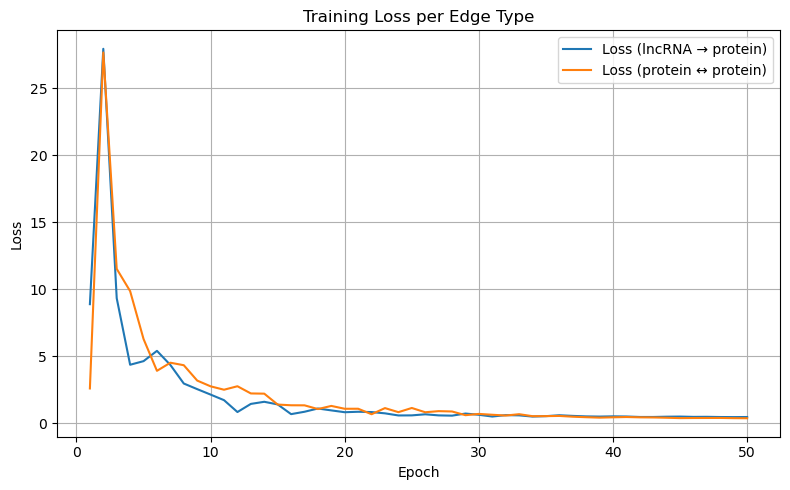

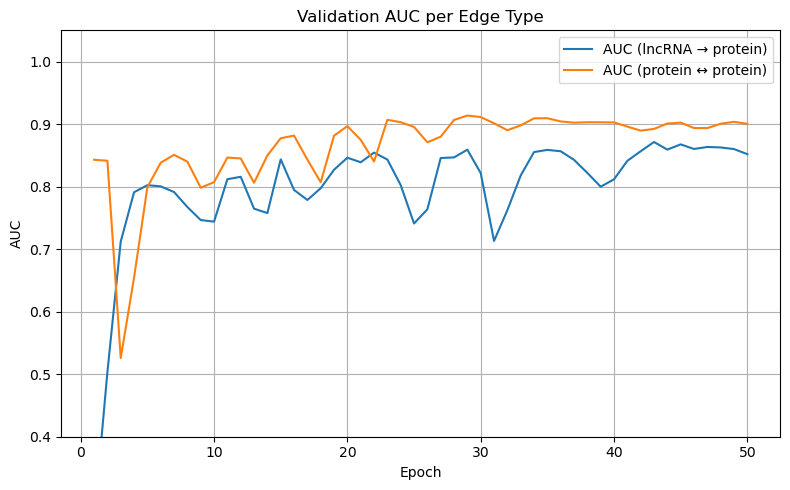

In [34]:
import matplotlib.pyplot as plt

# Get values from saved training history
loss_lnc_protein = loss_dict_all[('lncRNA', 'interacts', 'protein')]
loss_protein_protein = loss_dict_all[('protein', 'interacts', 'protein')]

auc_lnc_protein = auc_dict_all[('lncRNA', 'interacts', 'protein')]
auc_protein_protein = auc_dict_all[('protein', 'interacts', 'protein')]

# X-axis = epochs
epochs = list(range(1, len(loss_lnc_protein) + 1))

# --------- Plot Loss per edge type ---------
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_lnc_protein, label='Loss (lncRNA → protein)')
plt.plot(epochs, loss_protein_protein, label='Loss (protein ↔ protein)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Edge Type')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot AUC per edge type ---------
plt.figure(figsize=(8, 5))
plt.plot(epochs, auc_lnc_protein, label='AUC (lncRNA → protein)')
plt.plot(epochs, auc_protein_protein, label='AUC (protein ↔ protein)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC per Edge Type')
plt.ylim(0.4, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# Move the test graph to the same device (CPU or GPU)
test_data = test_data.to(device)

# Run evaluation on the test data
test_auc = evaluate(test_data, encoder, decoder)

# Print results
print("\nTest Set Evaluation:")
for edge_type, auc in test_auc.items():
    print(f"AUC ({edge_type[0]} → {edge_type[2]}): {auc:.4f}")



Test Set Evaluation:
AUC (lncRNA → protein): 0.8393
AUC (protein → protein): 0.9020


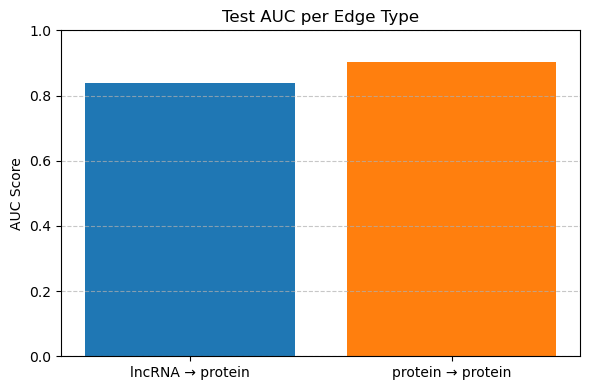

In [36]:
# Prepare bar plot
edge_labels = [f"{et[0]} → {et[2]}" for et in test_auc.keys()]
auc_values = list(test_auc.values())

plt.figure(figsize=(6, 4))
plt.bar(edge_labels, auc_values, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0.0, 1.0)
plt.title("Test AUC per Edge Type")
plt.ylabel("AUC Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()